In [4]:
import numpy as np
import matplotlib.pylab as plt
from scipy.misc import imresize, imread
%matplotlib inline

X = np.load('/home/reza/data/breast/X.npy') # images
Y = np.load('/home/reza/data/breast/Y.npy')

from keras.applications.xception import Xception, preprocess_input
model = Xception(include_top = True, weights = 'imagenet')
X_299 = np.array([imresize(xi, (299, 299)) for xi in X])
X_299 = preprocess_input(X_299.astype('float'))
xception_features = model.predict(X_299, verbose=1)
#xception_features=xception_features.reshape(5547,204800)

# I did the work for you ! 
#X = np.load('/home/reza/data/breast/xception_features.npy') # X shape (5547, 50, 50, 3)
#Y = np.load('/home/reza/data/breast/xception_Y.npy') #



5547/5547 [==============================] - 1261s 227ms/step


Using TensorFlow backend.


In [5]:
xception_features.shape

(5547, 1000)

In [20]:
import pandas as pd
Y_lavel=pd.DataFrame(Y)
Y_lavel.tail()

,0
5542,1
5543,1
5544,1
5545,1
5546,1


In [3]:
#xception_features=X.reshape(5547,204800)

# Standardization then visualization
#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE, SpectralEmbedding

#from sklearn.preprocessing import StandardScaler
#X_std=StandardScaler().fit_transform(xception_features)

#model = PCA(n_components=500) # Try to replace PCA by SpectralEmbedding, TSNE !
#PC_xception = model.fit_transform(X_std)

In [7]:
from sklearn.model_selection import StratifiedKFold as KFold

# Prepare the folds for a cross validation. We use the very useful scikit learn package. Here we use stratified 
# cross validation : the proportion of positive and negative examples is the same in all folds
N = len(xception_features)
folds = lambda : KFold(n_splits = 5, shuffle = True, random_state=0).split(xception_features, Y)

# Let's have a look to the split size and 

for i, (train_indexes, test_indexes) in enumerate(folds()):
    print('split {}: training : {} images, test : {} images'.format(i + 1, len(train_indexes), len(test_indexes)))

split 1: training : 4437 images, test : 1110 images
split 2: training : 4437 images, test : 1110 images
split 3: training : 4437 images, test : 1110 images
split 4: training : 4438 images, test : 1109 images
split 5: training : 4439 images, test : 1108 images


10 first predictions in probability : [ 0.   0.8  0.2  0.2  0.8  0.4  0.6  0.6  0.   0.8]
10 first predictions 0/1 :  [0 1 0 0 1 0 1 1 0 1]
10 first real labels     :  [0 0 0 0 0 0 0 0 0 0]
Accuracy : 65.12%
Confusion matrix (see wikipedia for more info)
[[1740 1019]
 [ 916 1872]]
AUC is the probability for a positive image to have a higher score than a negative image


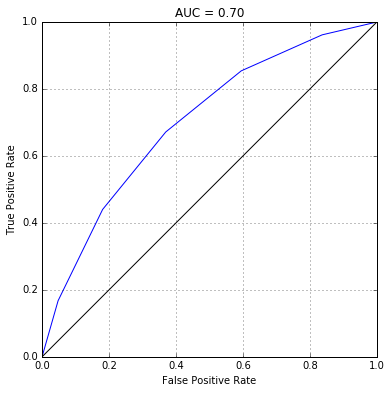

In [8]:
# Here we will use the k nearest neighbors algorithm : given a new image, find the k (e.g. k=10) images in the training set
# with the most similar histograms. If m of these neighors (e.g m=6) have label 1, then output p = 60%.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# This function run train the model ! 
def run_model(model, features):
    Y_pred = np.zeros(Y.shape)
    # For each fold :
    for train_indexes, valid_indexes in folds():
        # Train the model on the training data
        model.fit(features[train_indexes], Y[train_indexes])
        # And predict the results on the test data
        Y_pred[valid_indexes] = model.predict_proba(features[valid_indexes])[:,1]
    # Return all the predictions (probabilities between 0 and 1)
    return Y_pred

# Here we use kNN model : 
model = KNeighborsClassifier(n_neighbors=5, n_jobs=8)
# And call the function run_model
Y_pred = run_model(model, xception_features)

# Let's print the results
print('10 first predictions in probability : {}'.format(Y_pred[:10]))
Y_pred_01 = (Y_pred > 0.5).astype('int')
print('10 first predictions 0/1 :  {}'.format(Y_pred_01[:10]))
print('10 first real labels     :  {}'.format(Y[:10]))
print('Accuracy : {:.2f}%'.format(100 * np.mean(Y == Y_pred_01)))

print('Confusion matrix (see wikipedia for more info)')
print(confusion_matrix(Y, Y_pred_01))


plt.figure(figsize=(6,6))
fpr, tpr, _ = roc_curve(Y, Y_pred)
plt.plot(fpr, tpr)
plt.title('AUC = {:.2f}'.format(roc_auc_score(Y, Y_pred)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.plot([0,1],[0,1], 'black')
print('AUC is the probability for a positive image to have a higher score than a negative image')

accuracy = 65.12% at x = 5
accuracy = 65.24% at x = 6
accuracy = 66.18% at x = 7
accuracy = 66.23% at x = 8
accuracy = 66.54% at x = 9
accuracy = 66.38% at x = 10
accuracy = 66.70% at x = 11
accuracy = 66.52% at x = 12
accuracy = 67.21% at x = 13
accuracy = 67.14% at x = 14


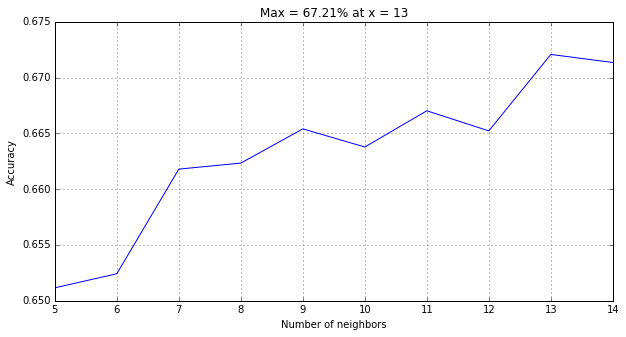

In [9]:
# Optimize the hyperparameters
# How does the accuracy evolves with the number of neighbors ?

def plot_accuracy(model, features, x_range):

    accuracy = []
    for x in x_range:
        accuracy.append(np.mean(Y == (run_model(model(x), features) > 0.5).astype('int')))
        print('accuracy = {:.2f}% at x = {}'.format(100*accuracy[-1], x))
    plt.figure(figsize=(10,5))
    plt.plot(x_range, accuracy)
    plt.xlabel('Number of neighbors')
    plt.xticks(x_range)
    plt.ylabel('Accuracy')
    plt.title('Max = {:.2f}% at x = {}'.format(100*np.max(accuracy), x_range[np.argmax(accuracy)]))
    plt.grid()
    
plot_accuracy(lambda k : KNeighborsClassifier(n_neighbors=k, n_jobs=8), xception_features, range(5,15))

accuracy = 65.12% at x = 5
accuracy = 66.38% at x = 10
accuracy = 67.44% at x = 15
accuracy = 68.31% at x = 20
accuracy = 67.98% at x = 25
accuracy = 67.68% at x = 30
accuracy = 67.80% at x = 35
accuracy = 68.36% at x = 40


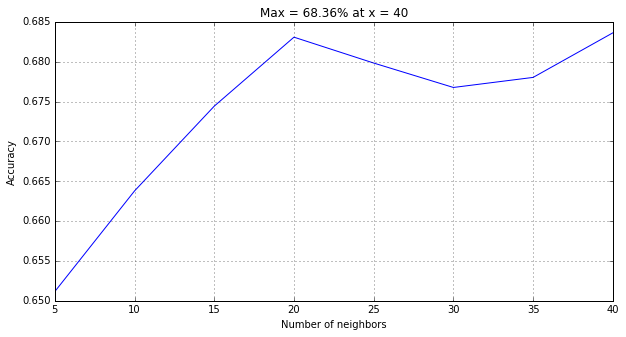

In [10]:
# Nearest NeighborsPC_xceptio
plot_accuracy(lambda k : KNeighborsClassifier(n_neighbors=k, n_jobs=8), xception_features, range(5,45,5))

accuracy = 75.05% at x = 5
accuracy = 76.35% at x = 10
accuracy = 76.24% at x = 15
accuracy = 76.69% at x = 20
accuracy = 76.22% at x = 25
accuracy = 76.55% at x = 30
accuracy = 76.47% at x = 35
accuracy = 76.55% at x = 40
accuracy = 76.40% at x = 45
accuracy = 76.76% at x = 50


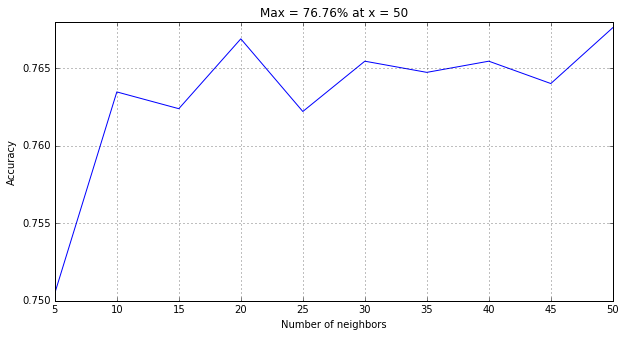

In [11]:
from sklearn.ensemble import RandomForestClassifier
plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              xception_features, range(5, 55, 5))

In [12]:
from sklearn.linear_model import LogisticRegression
Y_pred_01 = (run_model(LogisticRegression(n_jobs=8), xception_features) > 0.5).astype('int')
print 'Accuracy : {:.2f}%'.format(100* np.mean(Y == Y_pred_01))

Accuracy : 69.19%


/home/reza/.local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(self.n_jobs))


accuracy = 77.45% at x = 4
accuracy = 77.21% at x = 5
accuracy = 77.00% at x = 6


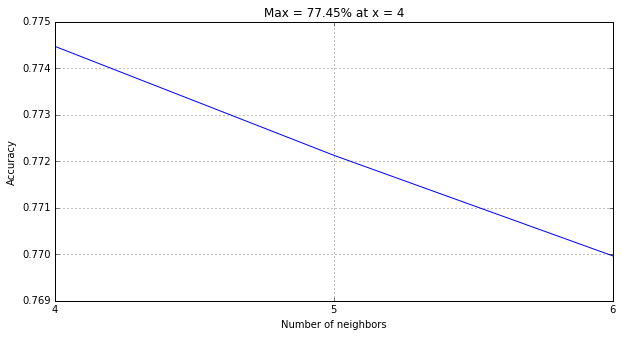

In [13]:
from xgboost import XGBClassifier
plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), xception_features, range(4, 7))

10 first predictions in probability : [ 0.27402687  0.80051666  0.19060171  0.11268057  0.16253749  0.48451063
  0.04308704  0.09879757  0.05866222  0.20939711]
10 first predictions 0/1 :  [0 1 0 0 0 0 0 0 0 0]
10 first real labels     :  [0 0 0 0 0 0 0 0 0 0]
Accuracy : 77.27%
Confusion matrix (see wikipedia for more info)
[[2118  641]
 [ 620 2168]]
AUC is the probability for a positive image to have a higher score than a negative image


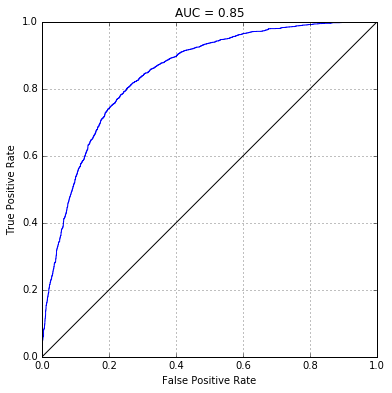

In [15]:
# Here we will use the k nearest neighbors algorithm : given a new image, find the k (e.g. k=10) images in the training set
# with the most similar histograms. If m of these neighors (e.g m=6) have label 1, then output p = 60%.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# This function run train the model ! 
def run_model(model, features):
    Y_pred = np.zeros(Y.shape)
    # For each fold :
    for train_indexes, valid_indexes in folds():
        # Train the model on the training data
        model.fit(features[train_indexes], Y[train_indexes])
        # And predict the results on the test data
        Y_pred[valid_indexes] = model.predict_proba(features[valid_indexes])[:,1]
    # Return all the predictions (probabilities between 0 and 1)
    return Y_pred

# Here we use kNN model : 
model = XGBClassifier(max_depth=3,n_estimators=500,learning_rate=0.1,nthread=-1,
 
                                   objective='binary:logistic',seed=42)

# And call the function run_model
Y_pred = run_model(model, xception_features)

# Let's print the results
print('10 first predictions in probability : {}'.format(Y_pred[:10]))
Y_pred_01 = (Y_pred > 0.5).astype('int')
print('10 first predictions 0/1 :  {}'.format(Y_pred_01[:10]))
print('10 first real labels     :  {}'.format(Y[:10]))
print('Accuracy : {:.2f}%'.format(100 * np.mean(Y == Y_pred_01)))

print('Confusion matrix (see wikipedia for more info)')
print(confusion_matrix(Y, Y_pred_01))


plt.figure(figsize=(6,6))
fpr, tpr, _ = roc_curve(Y, Y_pred)
plt.plot(fpr, tpr)
plt.title('AUC = {:.2f}'.format(roc_auc_score(Y, Y_pred)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.plot([0,1],[0,1], 'black')
print('AUC is the probability for a positive image to have a higher score than a negative image')

In [16]:
# Our feature will be the concatenation of the 3  histograms: red, green and blue. 

histogram_features = []
n_bins = 50 # We decide to keep 50 bins in the histogram, but you can try other values ! (up to 255)
for xi in X:
    hr = np.histogram(xi[:,:,0].flatten(), bins= n_bins)[0]
    hg = np.histogram(xi[:,:,1].flatten(), bins= n_bins)[0]
    hb = np.histogram(xi[:,:,2].flatten(), bins= n_bins)[0]
    hi = np.concatenate([hr, hg, hb])
    histogram_features.append(hi)

histogram_features = np.array(histogram_features)

print 'histogram shape : ', histogram_features.shape

histogram shape :  (5547, 150)


In [23]:
xcep_hist=np.column_stack((xception_features, histogram_features))

In [24]:
xcep_hist.shape

(5547, 1150)

accuracy = 77.30% at x = 5
accuracy = 78.42% at x = 10
accuracy = 78.46% at x = 15
accuracy = 78.51% at x = 20
accuracy = 79.14% at x = 25
accuracy = 78.85% at x = 30
accuracy = 78.67% at x = 35
accuracy = 78.29% at x = 40
accuracy = 78.93% at x = 45
accuracy = 78.53% at x = 50


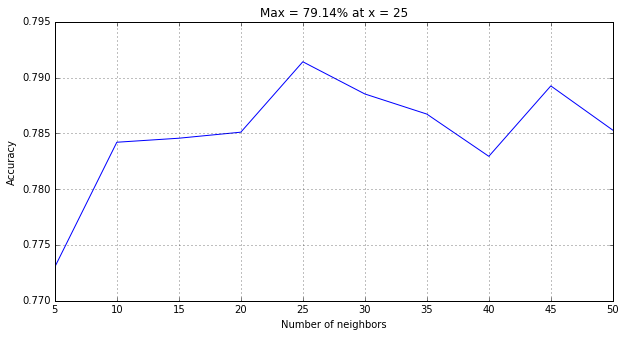

In [25]:
from sklearn.ensemble import RandomForestClassifier
plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              xcep_hist, range(5, 55, 5))

In [26]:
from sklearn.linear_model import LogisticRegression
Y_pred_01 = (run_model(LogisticRegression(n_jobs=8), xcep_hist) > 0.5).astype('int')
print 'Accuracy : {:.2f}%'.format(100* np.mean(Y == Y_pred_01))

Accuracy : 75.73%


accuracy = 79.23% at x = 3
accuracy = 80.01% at x = 4
accuracy = 80.04% at x = 5
accuracy = 80.28% at x = 6


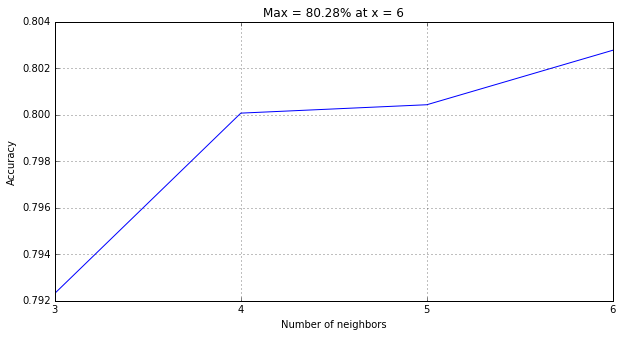

In [27]:
from xgboost import XGBClassifier
plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), xcep_hist, range(3, 7))

In [ ]:
np.save('/home/reza/data/breast/xcep_hist.npy', xcep_hist)

# INception+ Xception

In [7]:
import numpy as np
import matplotlib.pylab as plt
from scipy.misc import imresize, imread
%matplotlib inline

X = np.load('/home/reza/data/breast/X.npy') # images
Y = np.load('/home/reza/data/breast/Y.npy')

# from keras.applications.xception import Xception, preprocess_input
# model = Xception(include_top = True, weights = 'imagenet')
X_299 = np.array([imresize(xi, (299, 299)) for xi in X])
X_299 = preprocess_input(X_299.astype('float'))

X_224 = np.array([imresize(xi, (224, 224)) for xi in X])
X_224 = preprocess_input(X_224.astype('float'))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


In [8]:
X_299.shape

(5547, 299, 299, 3)

In [9]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

width = 299

def get_features(MODEL, data=X_299):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [10]:
inception_features = get_features(InceptionV3, X_299)
xception_features = get_features(Xception, X_299)
features = np.concatenate([inception_features, xception_features], axis=-1)

5547/5547 [==============================] - 1232s 222ms/step


In [11]:
inception_features.shape, xception_features.shape, features.shape

((5547, 2048), (5547, 2048), (5547, 4096))

In [12]:
np.save('/home/reza/data/breast/inception_feat.npy', inception_features)
np.save('/home/reza/data/breast/xception_feat.npy', xception_features)
np.save('/home/reza/data/breast/incep_xcep_feat.npy', features)

In [13]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input


import numpy as np
from scipy.misc import imresize, imread
%matplotlib inline


X = np.load('/home/reza/data/breast/X.npy') # X shape (5547, 50, 50, 3)
Y = np.load('/home/reza/data/breast/Y.npy') #
#model = ResNet50(weights='imagenet', include_top=False, pooling='max')
model = VGG16(weights='imagenet', include_top=False, pooling='max')

X_224 = np.array([imresize(xi, (224, 224)) for xi in X])
X_224 = preprocess_input(X_224.astype('float'))
vgg16_features = model.predict(X_224, verbose=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


5547/5547 [==============================] - 785s 142ms/step


In [15]:
np.save('/home/reza/data/breast/vgg16_features_maxpool.npy', vgg16_features)

In [16]:
vgg16_features.shape

(5547, 512)

In [23]:
# vgg16 = VGG16(weights='imagenet', include_top=False)

# x = vgg16.get_layer('block5_conv3').output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(1, activation='sigmoid')(x)

# model_final = Model(inputs=vgg16.input, outputs=x)
# vgg16_features_final = model_final.predict(X_224, verbose=1)

im_size=224
base_model = VGG16(weights='imagenet',include_top=False, input_shape=(im_size, im_size, 3))
# base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))
# Add a new top layer
x = base_model.output
x = Flatten()(x)
# This is the model we will train
model = Model(inputs=base_model.input, outputs=x)
vgg16_features_final = model.predict(X_224, verbose=1)

5547/5547 [==============================] - 779s 140ms/step


In [25]:
vgg16_features_final.shape

(5547, 25088)

In [26]:
width = 224

def get_features_vgg(MODEL, data=X_224):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [29]:
vgg16_features = get_features_vgg(VGG16, X_224)

5547/5547 [==============================] - 742s 134ms/step


In [30]:
vgg16_features.shape

(5547, 512)

In [31]:
np.save('/home/reza/data/breast/vgg16_feat.npy', vgg16_features)

In [2]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input


import numpy as np
from scipy.misc import imresize, imread
%matplotlib inline

X = np.load('/home/reza/data/breast/X.npy') # X shape (5547, 50, 50, 3)
Y = np.load('/home/reza/data/breast/Y.npy')
X_224 = np.array([imresize(xi, (224, 224)) for xi in X])
X_224 = preprocess_input(X_224.astype('float'))

width = 224

def get_features(MODEL, data=X_224):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features


vgg19_features = get_features(VGG19, X_224)
MobileNet_features = get_features(MobileNet, X_224)
InceptionResNetV2_features = get_features(InceptionResNetV2, X_224)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


5547/5547 [==============================] - 472s 85ms/step


In [3]:
resnet50_features = get_features(ResNet50, X_224)

5547/5547 [==============================] - 432s 78ms/step


In [4]:
resnet50_features.shape, vgg19_features.shape, MobileNet_features.shape, InceptionResNetV2_features.shape

((5547, 2048), (5547, 512), (5547, 1024), (5547, 1536))

In [5]:
np.save('/home/reza/data/breast/vgg19_feat.npy', vgg19_features)
np.save('/home/reza/data/breast/mobilenet_feat.npy', MobileNet_features)
np.save('/home/reza/data/breast/inception_resnet_feat.npy', InceptionResNetV2_features)
np.save('/home/reza/data/breast/resnet_feat.npy', resnet50_features)

In [6]:
# Our feature will be the concatenation of the 3  histograms: red, green and blue. 
X1 = np.load('/home/reza/data/breast/X.npy') # images
histogram_features = []
n_bins = 50 # We decide to keep 50 bins in the histogram, but you can try other values ! (up to 255)
for xi in X1:
    hr = np.histogram(xi[:,:,0].flatten(), bins= n_bins)[0]
    hg = np.histogram(xi[:,:,1].flatten(), bins= n_bins)[0]
    hb = np.histogram(xi[:,:,2].flatten(), bins= n_bins)[0]
    hi = np.concatenate([hr, hg, hb])
    histogram_features.append(hi)

histogram_features = np.array(histogram_features)
np.save('/home/reza/data/breast/hist_feat.npy', histogram_features)

# Pretained Model Analysis

In [2]:
import numpy as np
import matplotlib.pylab as plt
from scipy.misc import imresize, imread
%matplotlib inline

X = np.load('/home/reza/data/breast/X.npy')
Y = np.load('/home/reza/data/breast/Y.npy')

X_incep = np.load('/home/reza/data/breast/inception_feat.npy')
X_xcep = np.load('/home/reza/data/breast/xception_feat.npy')
X_vgg16 = np.load('/home/reza/data/breast/vgg16_feat.npy')
X_vgg19 = np.load('/home/reza/data/breast/vgg19_feat.npy')
X_mobile = np.load('/home/reza/data/breast/mobilenet_feat.npy')
X_incep_res = np.load('/home/reza/data/breast/inception_resnet_feat.npy')
X_resnet = np.load('/home/reza/data/breast/resnet_feat.npy')
X_incep_Xcep = np.load('/home/reza/data/breast/incep_xcep_feat.npy') 
X_hist = np.load('/home/reza/data/breast/hist_feat.npy') 
 

from sklearn.model_selection import StratifiedKFold as KFold

# Prepare the folds for a cross validation. We use the very useful scikit learn package. Here we use stratified 
# cross validation : the proportion of positive and negative examples is the same in all folds
N = len(X)
folds = lambda : KFold(n_splits = 5, shuffle = True, random_state=0).split(X, Y)

# Let's have a look to the split size and 

for i, (train_indexes, test_indexes) in enumerate(folds()):
    print('split {}: training : {} images, test : {} images'.format(i + 1, len(train_indexes), len(test_indexes)))

split 1: training : 4437 images, test : 1110 images
split 2: training : 4437 images, test : 1110 images
split 3: training : 4437 images, test : 1110 images
split 4: training : 4438 images, test : 1109 images
split 5: training : 4439 images, test : 1108 images


In [7]:
print("Inception Features Shape :", X_incep.shape)
print("Xception Features Shape :", X_xcep.shape)
print("VGG16 Features Shape :", X_vgg16.shape)
print("VGG19 Features Shape :", X_vgg19.shape)
print("MobileNet Features Shape :", X_mobile.shape)
print("InceptionV2_Resnet Features Shape :", X_incep_res.shape)
print("Resnet Features Shape :", X_resnet.shape)
print("Inception_Xception_Features Shape :", X_incep_Xcep.shape)
print("Histogram Features Shape :", X_hist.shape)

Inception Features Shape : (5547, 2048)
Xception Features Shape : (5547, 2048)
VGG16 Features Shape : (5547, 512)
VGG19 Features Shape : (5547, 512)
MobileNet Features Shape : (5547, 1024)
InceptionV2_Resnet Features Shape : (5547, 1536)
Resnet Features Shape : (5547, 2048)
Inception_Xception_Features Shape : (5547, 4096)
Histogram Features Shape : (5547, 150)


accuracy = 71.98% at x = 5
accuracy = 72.31% at x = 10
accuracy = 72.60% at x = 15
accuracy = 72.27% at x = 20
accuracy = 72.63% at x = 25
accuracy = 72.51% at x = 30
accuracy = 72.17% at x = 35
accuracy = 72.67% at x = 40
accuracy = 72.72% at x = 45
accuracy = 72.27% at x = 50
accuracy = 70.40% at x = 5
accuracy = 71.55% at x = 10
accuracy = 71.70% at x = 15
accuracy = 71.73% at x = 20
accuracy = 71.84% at x = 25
accuracy = 71.55% at x = 30
accuracy = 71.86% at x = 35
accuracy = 71.82% at x = 40
accuracy = 71.66% at x = 45
accuracy = 72.00% at x = 50
accuracy = 75.39% at x = 5
accuracy = 76.44% at x = 10
accuracy = 76.60% at x = 15
accuracy = 76.76% at x = 20
accuracy = 76.58% at x = 25
accuracy = 77.07% at x = 30
accuracy = 77.14% at x = 35
accuracy = 76.98% at x = 40
accuracy = 77.00% at x = 45
accuracy = 77.32% at x = 50
accuracy = 71.86% at x = 5
accuracy = 73.55% at x = 10
accuracy = 73.70% at x = 15
accuracy = 73.70% at x = 20
accuracy = 74.04% at x = 25
accuracy = 73.30% at x =

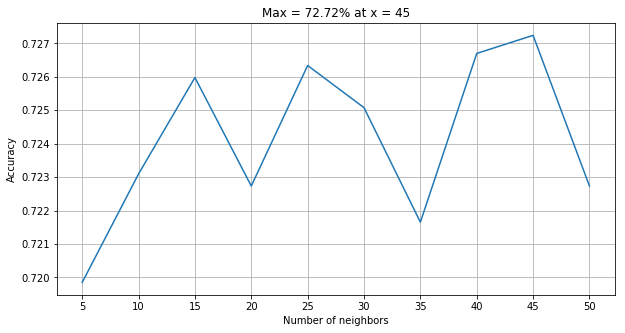

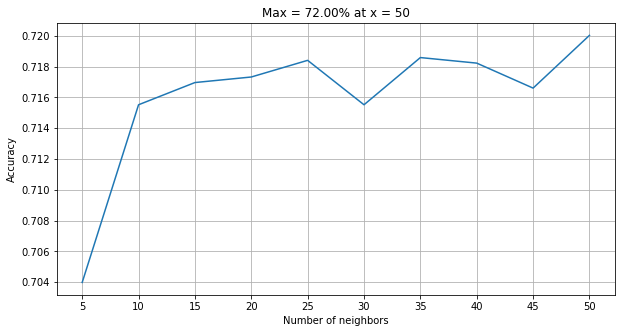

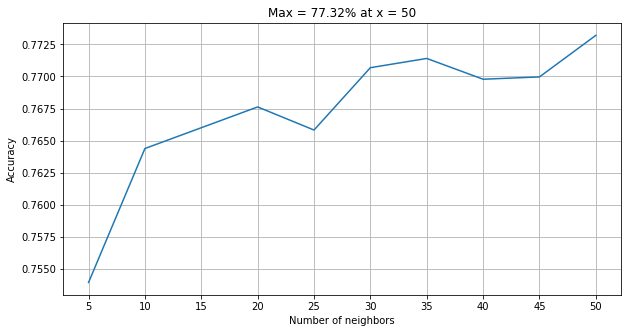

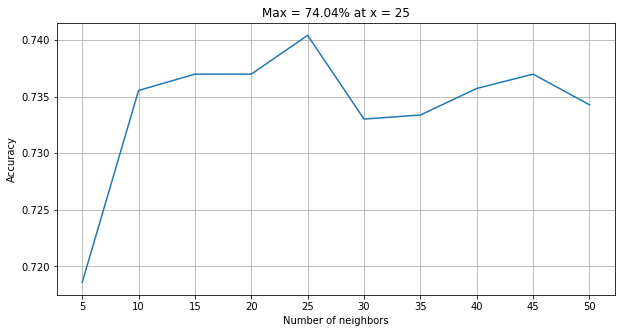

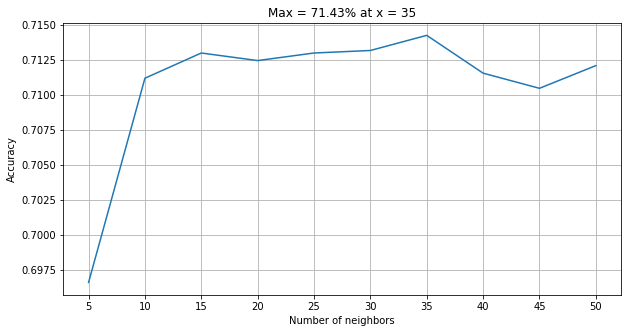

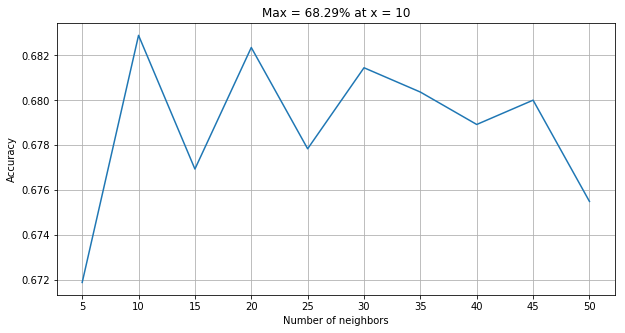

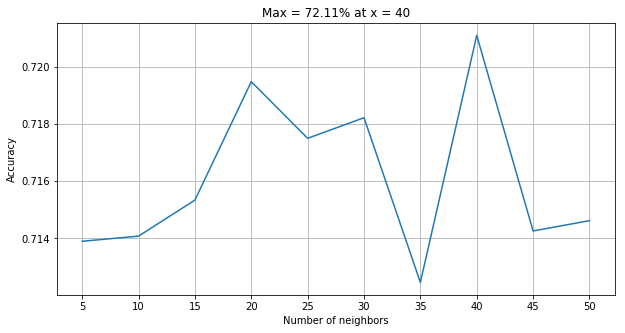

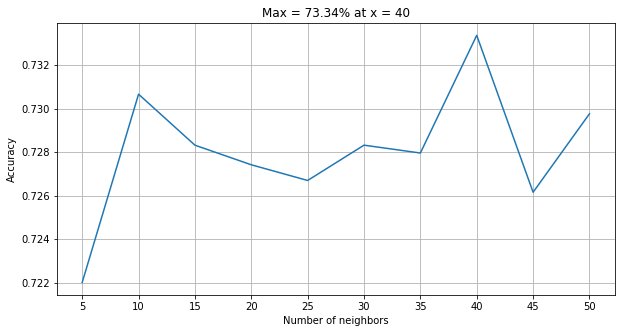

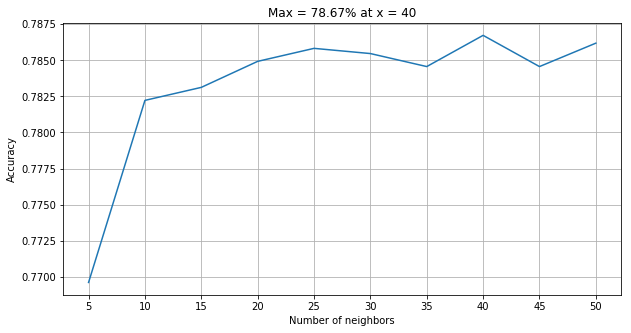

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# This function run train the model ! 
def run_model(model, features):
    Y_pred = np.zeros(Y.shape)
    # For each fold :
    for train_indexes, valid_indexes in folds():
        # Train the model on the training data
        model.fit(features[train_indexes], Y[train_indexes])
        # And predict the results on the test data
        Y_pred[valid_indexes] = model.predict_proba(features[valid_indexes])[:,1]
    # Return all the predictions (probabilities between 0 and 1)
    return Y_pred

def plot_accuracy(model, features, x_range):

    accuracy = []
    for x in x_range:
        accuracy.append(np.mean(Y == (run_model(model(x), features) > 0.5).astype('int')))
        print('accuracy = {:.2f}% at x = {}'.format(100*accuracy[-1], x))
    plt.figure(figsize=(10,5))
    plt.plot(x_range, accuracy)
    plt.xlabel('Number of neighbors')
    plt.xticks(x_range)
    plt.ylabel('Accuracy')
    plt.title('Max = {:.2f}% at x = {}'.format(100*np.max(accuracy), x_range[np.argmax(accuracy)]))
    plt.grid()
 
print("Inception Features Shape :", X_incep.shape)
from sklearn.ensemble import RandomForestClassifier
plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              X_incep, range(5, 55, 5))

print("Xception Features Shape :", X_xcep.shape)

plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              X_xcep, range(5, 55, 5))

print("VGG16 Features Shape :", X_vgg16.shape)

plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              X_vgg16, range(5, 55, 5))

print("VGG19 Features Shape :", X_vgg19.shape)

plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              X_vgg19, range(5, 55, 5))

print("MobileNet Features Shape :", X_mobile.shape)

plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              X_mobile, range(5, 55, 5))

print("InceptionV2_Resnet Features Shape :", X_incep_res.shape)

plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              X_incep_res, range(5, 55, 5))

print("Resnet Features Shape :", X_resnet.shape)

plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              X_resnet, range(5, 55, 5))

print("Inception_Xception_Features Shape :", X_incep_Xcep.shape)

plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              X_incep_Xcep, range(5, 55, 5))

print("Histogram Features Shape :", X_hist.shape)

plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              X_hist, range(5, 55, 5))

Inception Features Shape : (5547, 2048)
accuracy = 72.02% at x = 3
accuracy = 72.47% at x = 4
accuracy = 72.89% at x = 5
accuracy = 72.90% at x = 6
Xception Features Shape : (5547, 2048)
accuracy = 73.32% at x = 3
accuracy = 73.37% at x = 4
accuracy = 73.81% at x = 5
accuracy = 73.97% at x = 6
VGG16 Features Shape : (5547, 512)
accuracy = 77.99% at x = 3
accuracy = 77.88% at x = 4
accuracy = 77.84% at x = 5
accuracy = 78.35% at x = 6
VGG19 Features Shape : (5547, 512)
accuracy = 73.99% at x = 3
accuracy = 74.33% at x = 4
accuracy = 73.91% at x = 5
accuracy = 74.11% at x = 6
MobileNet Features Shape : (5547, 1024)
accuracy = 71.39% at x = 3
accuracy = 71.10% at x = 4
accuracy = 71.70% at x = 5
accuracy = 72.35% at x = 6
InceptionV2_Resnet Features Shape : (5547, 1536)
accuracy = 68.97% at x = 3
accuracy = 68.58% at x = 4
accuracy = 69.17% at x = 5
accuracy = 69.70% at x = 6
Resnet Features Shape : (5547, 2048)
accuracy = 72.22% at x = 3
accuracy = 71.70% at x = 4
accuracy = 72.24% at x 

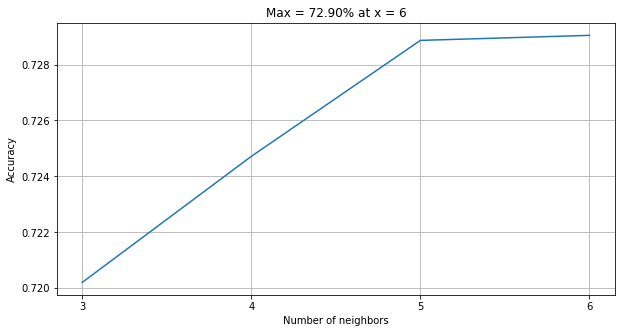

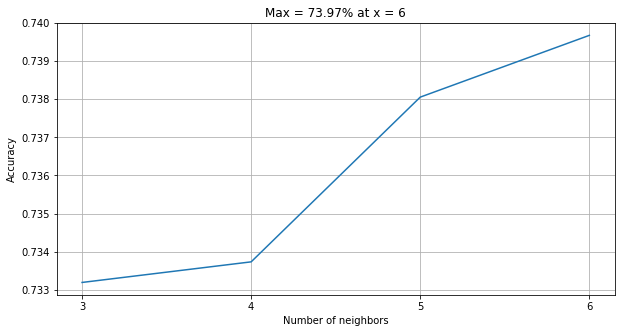

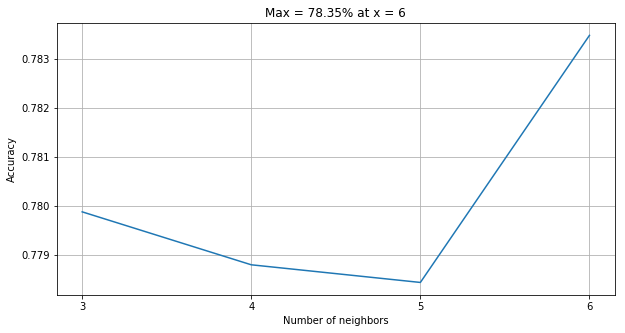

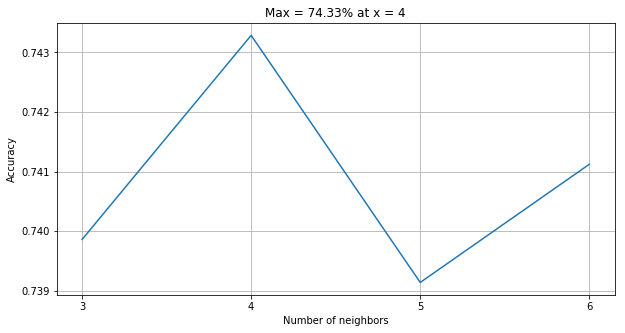

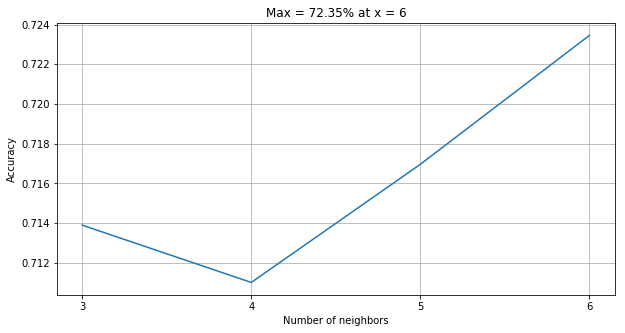

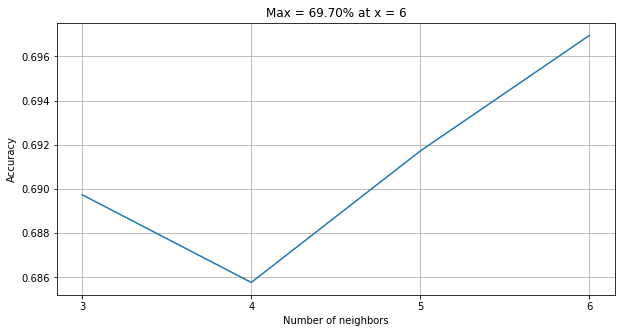

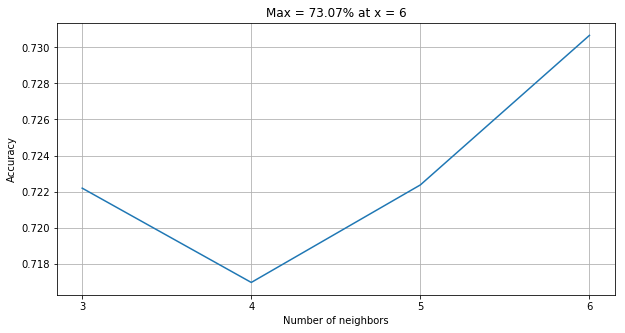

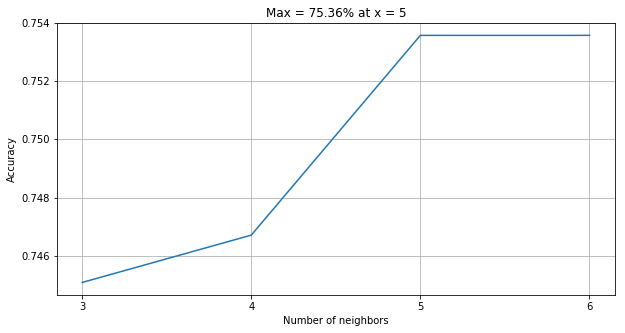

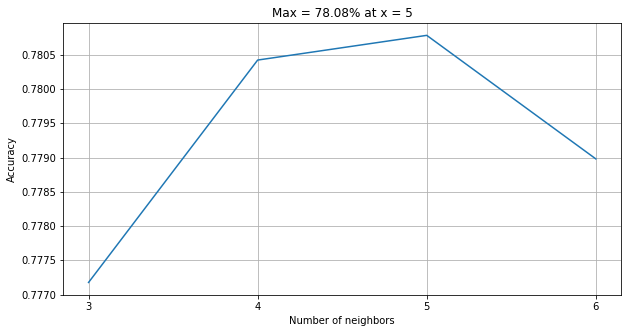

In [10]:
from xgboost import XGBClassifier

print("Inception Features Shape :", X_incep.shape)
plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), X_incep, range(3, 7))

print("Xception Features Shape :", X_xcep.shape)

plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), X_xcep, range(3, 7))

print("VGG16 Features Shape :", X_vgg16.shape)

plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), X_vgg16, range(3, 7))

print("VGG19 Features Shape :", X_vgg19.shape)

plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), X_vgg19, range(3, 7))

print("MobileNet Features Shape :", X_mobile.shape)

plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), X_mobile, range(3, 7))

print("InceptionV2_Resnet Features Shape :", X_incep_res.shape)

plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), X_incep_res, range(3, 7))

print("Resnet Features Shape :", X_resnet.shape)

plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), X_resnet, range(3, 7))

print("Inception_Xception_Features Shape :", X_incep_Xcep.shape)

plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), X_incep_Xcep, range(3, 7))

print("Histogram Features Shape :", X_hist.shape)

plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), X_hist, range(3, 7))

In [11]:
vgg16_hist=np.concatenate([X_vgg16, X_hist], axis=1)

accuracy = 77.72% at x = 5
accuracy = 78.85% at x = 10
accuracy = 79.11% at x = 15
accuracy = 79.20% at x = 20
accuracy = 78.91% at x = 25
accuracy = 78.89% at x = 30
accuracy = 79.11% at x = 35
accuracy = 79.52% at x = 40
accuracy = 79.02% at x = 45
accuracy = 79.00% at x = 50


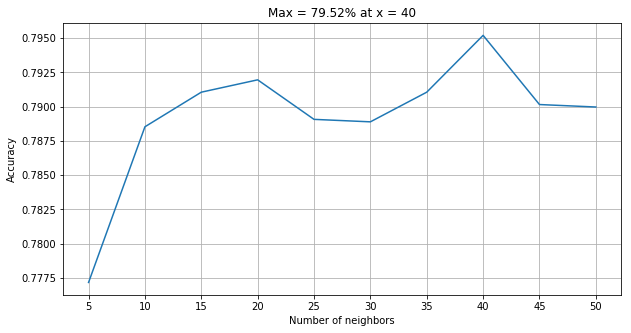

In [13]:
plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              vgg16_hist, range(5, 55, 5))

accuracy = 79.83% at x = 4
accuracy = 80.15% at x = 5
accuracy = 79.95% at x = 6


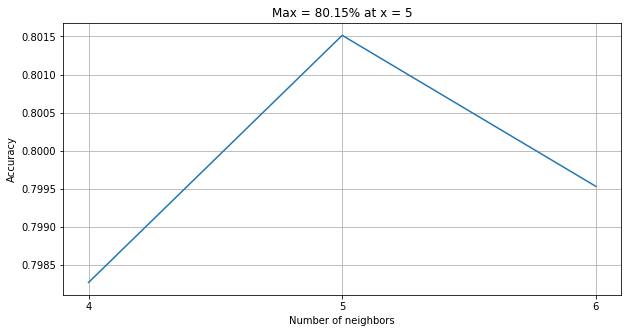

In [14]:
plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), vgg16_hist, range(4, 7))

In [18]:
resnet_hist=np.load('/home/reza/data/breast/res_hist.npy')

accuracy = 78.51% at x = 5
accuracy = 78.94% at x = 10
accuracy = 79.29% at x = 15
accuracy = 79.32% at x = 20
accuracy = 79.50% at x = 25
accuracy = 79.16% at x = 30
accuracy = 79.38% at x = 35
accuracy = 79.29% at x = 40
accuracy = 79.38% at x = 45
accuracy = 79.14% at x = 50
accuracy = 80.31% at x = 4
accuracy = 80.30% at x = 5
accuracy = 80.55% at x = 6


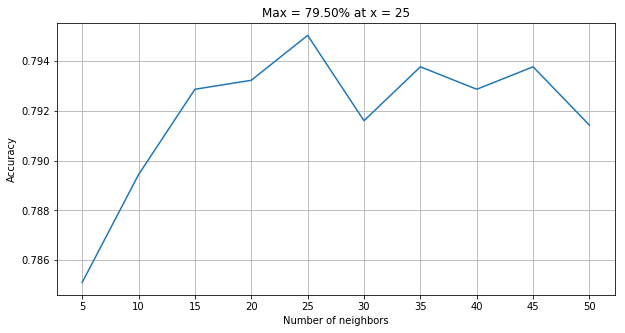

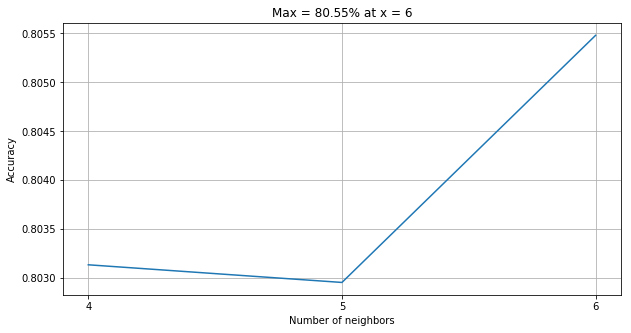

In [19]:
plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              resnet_hist, range(5, 55, 5))

plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), resnet_hist, range(4, 7))

accuracy = 80.62% at x = 7
accuracy = 80.51% at x = 8


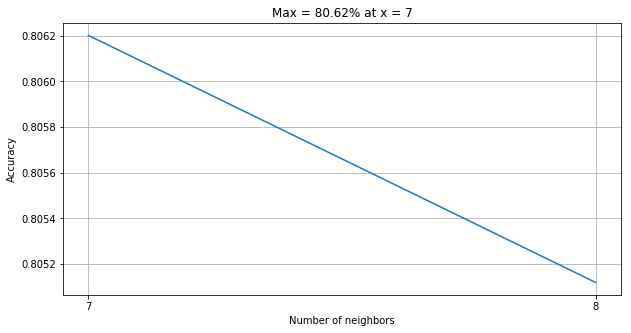

In [20]:
plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), resnet_hist, range(7, 9))

In [21]:
vgg16_res_his=np.concatenate([X_vgg16, resnet_hist], axis=1)
vgg16_res_his.shape

(5547, 2710)

accuracy = 78.26% at x = 5
accuracy = 79.00% at x = 10
accuracy = 79.14% at x = 15
accuracy = 79.30% at x = 20
accuracy = 79.20% at x = 25
accuracy = 79.18% at x = 30
accuracy = 79.09% at x = 35
accuracy = 79.25% at x = 40
accuracy = 79.02% at x = 45
accuracy = 79.29% at x = 50
accuracy = 80.80% at x = 6
accuracy = 81.05% at x = 7


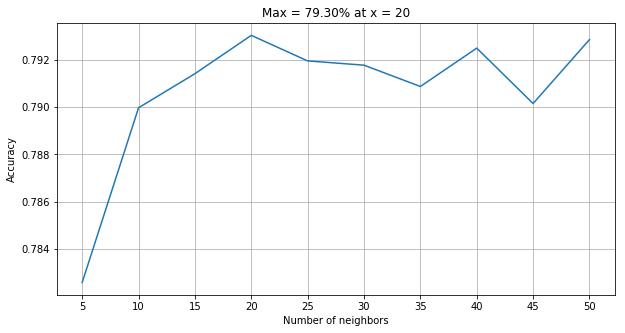

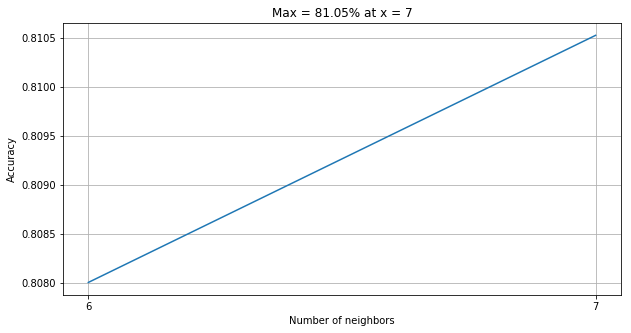

In [22]:
plot_accuracy(lambda d : RandomForestClassifier(n_estimators = 300, max_depth = d, n_jobs=8),
              vgg16_res_his, range(5, 55, 5))

plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), vgg16_res_his, range(6, 8))

In [ ]:
plot_accuracy(lambda d : XGBClassifier(max_depth=d,n_estimators=500,learning_rate=0.1,nthread=-1,
                                       objective='binary:logistic',seed=42), vgg16_res_his, range(8, 10))

accuracy = 80.57% at x = 8
